In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
train_full = pd.read_csv('train.csv')
test_full = pd.read_csv('test.csv')

train_y = train_full.iloc[:, 0] == 'M'
train_X = train_full.iloc[:,1:]
test_y = test_full.iloc[:, 0] == 'M'
test_X = test_full.iloc[:,1:]

# Standardization

In [3]:
mu = train_X.mean(axis=0)
sigma = train_X.std(axis=0)

In [4]:
train_X_std = (train_X - mu)/sigma
test_X_std = (test_X - mu)/sigma

# Plots

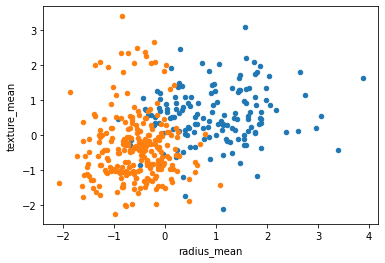

In [5]:
ax = train_X_std[train_y].plot(kind='scatter', x='radius_mean', y='texture_mean')
train_X_std[~train_y].plot(kind='scatter', x='radius_mean', y='texture_mean', ax=ax, color='C1')

In [6]:
def fit_gaussian(X):
    mu = X.mean(axis=0)
    C = (X - mu).T @ (X - mu) / len(X)
    return mu, C

In [7]:
mu_1, C_1 = fit_gaussian(train_X_std[train_y])
mu_0, C_0 = fit_gaussian(train_X_std[~train_y])

## Full Gaussians

In [8]:
n = len(train_X_std)
n_1 = train_y.sum()
n_0 = n - n_1

p_1 = scipy.stats.multivariate_normal.pdf(train_X_std, mu_1, C_1) * n_1 / n
p_0 = scipy.stats.multivariate_normal.pdf(train_X_std, mu_0, C_0) * n_0 / n

In [9]:
1 - ((p_1 > p_0) == train_y).mean()

0.03249999999999997

In [10]:
p_1_test = scipy.stats.multivariate_normal.pdf(test_X_std, mu_1, C_1) * n_1 / n
p_0_test = scipy.stats.multivariate_normal.pdf(test_X_std, mu_0, C_0) * n_0 / n

In [11]:
1 - ((p_1_test > p_0_test) == test_y).mean()

0.029585798816568087

## Diagonal Gaussians

In [12]:
def fit_diagonal_gaussian(X):
    mu = X.mean(axis=0)
    C = np.diag(X.var())
    return mu, C

In [13]:
mu_1, C_1 = fit_diagonal_gaussian(train_X_std[train_y])
mu_0, C_0 = fit_diagonal_gaussian(train_X_std[~train_y])

C = (n_1 * C_1 + n_0 * C_0) / (n_1 + n_0)

p_1 = scipy.stats.multivariate_normal.pdf(train_X_std, mu_1, C) * n_1 / n
p_0 = scipy.stats.multivariate_normal.pdf(train_X_std, mu_0, C) * n_0 / n

In [14]:
((p_1 > p_0) == train_y).mean()

0.94

In [15]:
p_1_test = scipy.stats.multivariate_normal.pdf(test_X_std, mu_1, C) * n_1 / n
p_0_test = scipy.stats.multivariate_normal.pdf(test_X_std, mu_0, C) * n_0 / n

In [16]:
1 - ((p_1_test > p_0_test) == test_y).mean()

0.18934911242603547

In [17]:
train_X

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.950,20.01,114.20,982.0,0.08402,0.06722,0.072930,0.055960,0.2129,0.05025,...,20.58,27.83,129.20,1261.0,0.10720,0.12020,0.22490,0.11850,0.4882,0.06111
1,13.000,21.82,87.50,519.8,0.12730,0.19320,0.185900,0.093530,0.2350,0.07389,...,15.49,30.73,106.20,739.3,0.17030,0.54010,0.53900,0.20600,0.4378,0.10720
2,15.300,25.27,102.40,732.4,0.10820,0.16970,0.168300,0.087510,0.1926,0.06540,...,20.27,36.71,149.30,1269.0,0.16410,0.61100,0.63350,0.20240,0.4027,0.09876
3,13.530,10.94,87.91,559.2,0.12910,0.10470,0.068770,0.065560,0.2403,0.06641,...,14.08,12.49,91.36,605.5,0.14510,0.13790,0.08539,0.07407,0.2710,0.07191
4,11.300,18.19,73.93,389.4,0.09592,0.13250,0.154800,0.028540,0.2054,0.07669,...,12.58,27.96,87.16,472.9,0.13470,0.48480,0.74360,0.12180,0.3308,0.12970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,9.683,19.34,61.05,285.7,0.08491,0.05030,0.023370,0.009615,0.1580,0.06235,...,10.93,25.59,69.10,364.2,0.11990,0.09546,0.09350,0.03846,0.2552,0.07920
396,13.500,12.71,85.69,566.2,0.07376,0.03614,0.002758,0.004419,0.1365,0.05335,...,14.97,16.94,95.48,698.7,0.09023,0.05836,0.01379,0.02210,0.2267,0.06192
397,12.750,16.70,82.51,493.8,0.11250,0.11170,0.038800,0.029950,0.2120,0.06623,...,14.45,21.74,93.63,624.1,0.14750,0.19790,0.14230,0.08045,0.3071,0.08557
398,23.210,26.97,153.50,1670.0,0.09509,0.16820,0.195000,0.123700,0.1909,0.06309,...,31.01,34.51,206.00,2944.0,0.14810,0.41260,0.58200,0.25930,0.3103,0.08677
